<a href="https://colab.research.google.com/github/joaochenriques/PID_WellsTurbine/blob/main/PID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The PID controller is described by the equation:

$$u={{K}_{p}}e(t)+{{K}_{i}}\int\limits_{0}^{t}{e(\tau )d\tau }+{{K}_{d}}\frac{de(t)}{dt}$$

Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pathlib, subprocess, os

In [2]:
def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

In [3]:
if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

Several global variables are necessary as the history of the object is used for calculations.

In [9]:
time_cur = 0
integral = 0
time_prev = -1e-6
e_prev = 0

The function below calculates the value of manipulated variable (MV) based on the measured value (in example it is the temperature of the liquid) and setpoint value (temperature we want to obtain).

In [10]:
def PID(Kp, Ki, Kd, setpoint, measurement):
    global time_cur, integral, time_prev, e_prev

    # Value of offset - when the error is equal zero
    offset = 320

    # PID calculations
    e = setpoint - measurement

    P = Kp*e
    integral = integral + Ki*e*(time_cur - time_prev)
    D = Kd*(e - e_prev)/(time_cur - time_prev)

    # calculate manipulated variable - MV
    MV = offset + P + integral + D

    # update stored data for next iteration
    e_prev = e
    time_prev = time_cur
    return MV

We will test the above function in the following system. It is a tank with a heating jacket. The lquid supplied to the tank is heated up to a desired temperature. The derivation of the mathematical model is presented in Lecture notes in process control, <a href="https://softinery.com/wp-content/uploads/blog/process-control/Lecture_4.pdf">lecture 4</a>

<center><img src = "tank.jpg" width = "500px"></center>


$$ \frac{dT}{dt}=\frac{1}{1+\varepsilon }\left[ \frac{1}{\tau }({{T}_{f}}-T)+Q({{T}_{q}}-T) \right] $$

$$\varepsilon =\frac{{{m}_{s}}{{c}_{s}}}{V\rho {{c}_{p}}},\ Q=\frac{{{A}_{q}}{{k}_{q}}}{V\rho {{c}_{p}}},\ \tau =\frac{V}{{{F}_{V}}}$$

The implementation of the mathematical model.

In [11]:
def system(t, temp, Tq):
    epsilon = 1
    tau = 4
    Tf = 300
    Q = 2
    dTdt = 1/(tau*(1+epsilon)) * (Tf-temp) + Q/(1+epsilon)*(Tq-temp)
    return dTdt

Results of the operation of uncontrolled system.

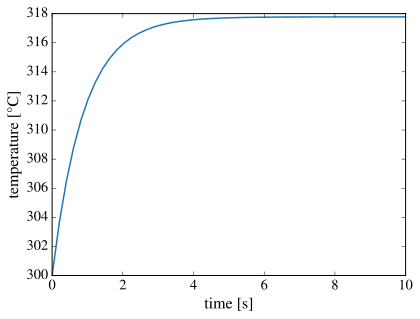

In [12]:
tspan = np.linspace(0,10,50)
Tq = 320,
sol = odeint(system,300, tspan, args=Tq, tfirst=True)
plt.xlabel('time [s]')
plt.ylabel('temperature [°C]')
plt.plot(tspan,sol)

The code below simulates the controlled system.

Text(0, 0.5, 'temperature [°C]')

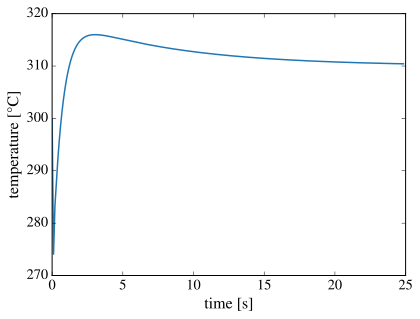

In [14]:
# number of steps
n = 250
time_prev = 0
y0 = 300
deltat = 0.1
y_sol = [y0]
t_sol = [time_prev]
# Tq is chosen as a manipulated variable
Tq = 320,
q_sol = [Tq[0]]
setpoint = 310
integral = 0
for i in range(1, n):
    time_cur = i * deltat
    tspan = np.linspace(time_prev, time_cur, 10)
    Tq = PID(0.6, 0.2, 0.1, setpoint, y_sol[-1]),
    yi = odeint(system,y_sol[-1], tspan, args = Tq, tfirst=True)
    t_sol.append(time_cur)
    y_sol.append(yi[-1][0])
    q_sol.append(Tq[0])
    time_prev = time_cur

plt.plot(t_sol, y_sol)
plt.xlabel('time [s]')
plt.ylabel('temperature [°C]')

In [15]:
freq = 0.81
timeSpan = np.linspace(0,2,101)
Δp = 200.0 * np.sin( 2*np.pi*freq*timeSpan )
timeSpan

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [16]:
Kt = 0.01
Ω = 250
D = 1.0
Cd = 0.66
ρ = 1.2

Kv = ( Kt * D / ( ρ * Ω * Cd ) )**2 * ρ / 2.0
A2 = Kv * np.abs( Δp )
Dd = np.sqrt( 4 / np.pi * np.sqrt( A2 ) )

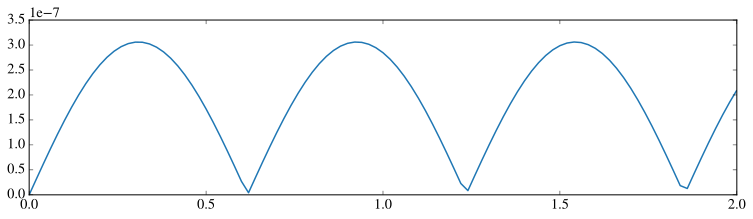

In [17]:
plt.figure( 1, figsize = (12, 3) )
plt.plot( timeSpan, A2 );

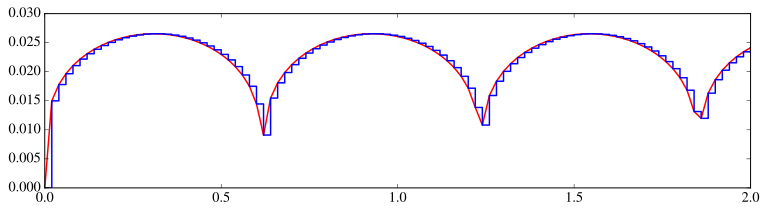

In [18]:
plt.figure( 1, figsize = (12, 3) )
plt.plot( timeSpan, Dd, 'r-' );
plt.plot( np.repeat(timeSpan, 2)[1:], np.repeat(Dd, 2)[:-1], 'b-' );